In [1]:
%cd /content/drive/MyDrive/detectron/format

/content/drive/MyDrive/detectron/format


In [2]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

     |████████████████████████████████| 274 kB 9.0 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=18124bf8042f85b92e605c5108f9faef108aa30a69d0b19adf0b8f3ee27e12f4
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
torch:  1.10 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html
     |████████████████████████████████| 7.0 MB 7.7 MB/s 
     |████████████████████████████████| 74 kB 3.2 MB/s 
     |████████████████████████████████| 49 kB 7.2 MB/s 
     |████████████████████████████████| 145 kB 18.0 MB/s 
     |████████████████████████████████| 130 kB 73.5 MB/s 
     |████████████████████████████████| 843 kB 63.8 MB/s 
     |███████████████████████████████

In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
# coco 데이터셋에 sia 객체 instance를 추가해준다.
from detectron2.data.datasets import register_coco_instances
register_coco_instances("sia", {}, "/content/drive/MyDrive/detectron/format/traincoco.json", "/content/drive/MyDrive/sia/train/images")
sia_metadata = MetadataCatalog.get("sia")
dataset_dicts = DatasetCatalog.get("sia")

[12/06 12:12:49 d2.data.datasets.coco]: Loading /content/drive/MyDrive/detectron/format/traincoco.json takes 6.32 seconds.
[12/06 12:12:49 d2.data.datasets.coco]: Loaded 1748 images in COCO format from /content/drive/MyDrive/detectron/format/traincoco.json


In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

num_gpu = 1
bs = (num_gpu * 2)

cfg = get_cfg()
cfg.merge_from_file("/content/drive/MyDrive/detectron/detectron2/configs/COCO-Detection/retinanet_R_101_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("sia",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/retinanet_R_101_FPN_3x/190397697/model_final_971ab9.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  
cfg.SOLVER.BASE_LR = 0.02 * bs / 16
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.GAMMA = 0.05
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 21  # 21 classes

Loading config /content/drive/MyDrive/detectron/detectron2/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [ ]:
# predictor 명시
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/detectron/output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.55   # set the testing threshold for this model
cfg.DATASETS.TEST = ("sia", )
predictor = DefaultPredictor(cfg)

In [ ]:
# path = "/content/drive/MyDrive/sia/train/images/OBJ01735_PS3_K3_NIA0104.png"
path = '/content/drive/MyDrive/sia/train/images/OBJ00013_PS3_K3_NIA0078.png'
im = cv2.imread(path)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

Output hidden; open in https://colab.research.google.com to view.

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


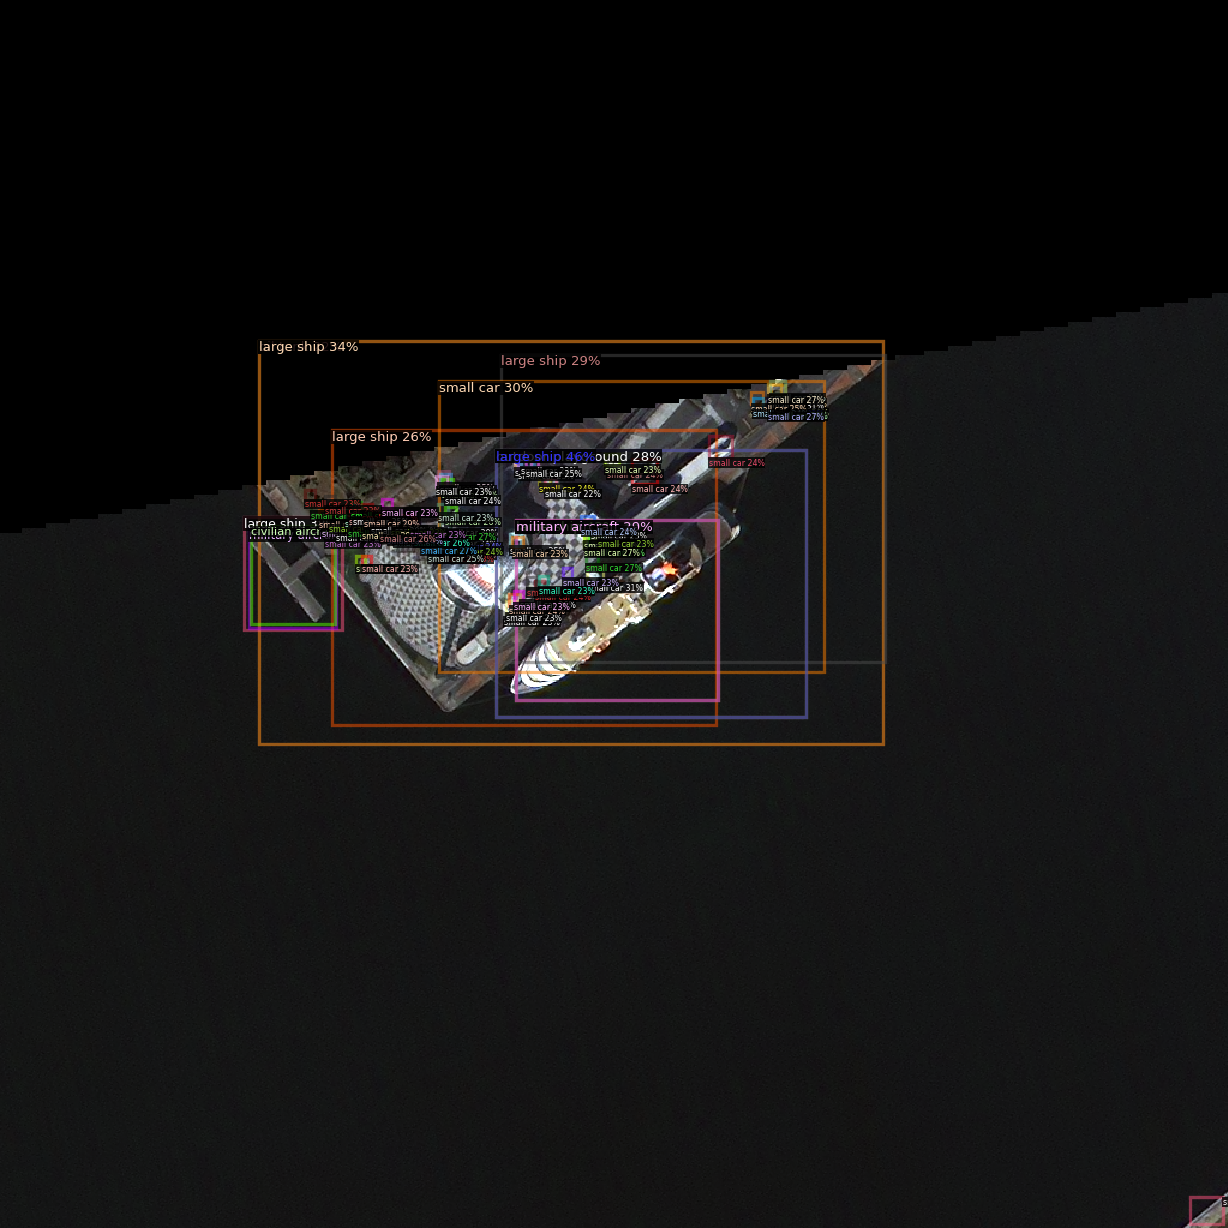

In [ ]:
path = "/content/drive/MyDrive/sia/train/images/OBJ00022_PS3_K3_NIA0078.png"

im = cv2.imread(path)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
path = "/content/drive/MyDrive/sia/train/images/OBJ02457_PS3_K3_NIA0123.png"

im = cv2.imread(path)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
path = "/content/drive/MyDrive/sia/train/images/OBJ00258_PS3_K3_NIA0081.png"

im = cv2.imread(path)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# output 정보 확인
print(outputs['instances'].image_size)
print(list(outputs['instances'].get_fields().keys()))

(1024, 1024)
['pred_boxes', 'scores', 'pred_classes']


In [ ]:
from detectron2.utils.visualizer import ColorMode

im = cv2.imread("/content/drive/MyDrive/sia/train/images/OBJ03368_PS3_K3A_NIA0137.png")

print('------------------------ 1 ------------------------')
print(outputs['instances'].image_size)

print('------------------------ 2 ------------------------')
print(outputs['instances'].get_fields().keys())

print('------------------- 2.1 pred_boxes ----------------')
print(outputs['instances'].get_fields()['pred_boxes'])

print('------------------- 2.2 scores --------------------')
print(outputs['instances'].get_fields()['scores'])

print('------------------- 2.3 pred_classes ---------------')
print(outputs['instances'].get_fields()['pred_classes'])

------------------------ 1 ------------------------
(1024, 1024)
------------------------ 2 ------------------------
dict_keys(['pred_boxes', 'scores', 'pred_classes'])
------------------- 2.1 pred_boxes ----------------
Boxes(tensor([[ 876.1610,  890.4789,  884.8916,  897.9832],
        [ 874.1849,  893.7620,  882.7132,  901.8221],
        [ 869.2263,  895.2919,  878.0541,  903.2501],
        [ 870.8427,  893.5079,  879.7260,  901.1089],
        [ 883.5486,  887.0319,  891.9937,  894.5812],
        [ 879.8266,  884.2522,  888.7591,  891.4425],
        [ 884.6149,  882.2247,  893.1657,  889.5475],
        [ 864.9759,  902.6689,  874.2739,  911.0851],
        [ 991.7205,  796.1784, 1000.9766,  803.8267],
        [ 216.5511,  976.9902,  224.6192,  986.0771],
        [ 996.5790,  788.6875, 1006.4589,  795.9639],
        [ 863.9114,  896.6287,  873.0024,  904.4102],
        [ 542.0270,  897.0563,  549.8886,  905.2372],
        [ 541.1805,  889.1988,  549.0084,  897.4266],
        [ 872.366

In [ ]:
print('----------------------- 3 -------------------------')
v = Visualizer(im[:, :, ::-1],
               metadata=sia_metadata,
               scale=1.2
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print('----------------------- 4 -------------------------')

idex_csv = 1
objs_info_images = []
objs_info_images.append([])

# for image in images :
# images 가져오고 output 계산하기
object_num = outputs['instances'].get_fields()['scores'].shape[0]
for i in range(object_num) :
  obj_info = []

  image_name = 'images name'  # file_name
  obj_info.append(image_name)

  obj_info.append(outputs['instances'].get_fields()['pred_classes'].cpu().numpy()[i]+1) # class_id
  obj_info.append(outputs['instances'].get_fields()['scores'].cpu().numpy()[i]) # score
  obj_info.append(outputs[''])
  
  obj_rbox = obj_info.append(outputs['instances'].get_fields()['pred_boxes'].numpy()[i]+1)

  #pred_masks_obects_int = (pred_masks_tensor[i,:,:].cpu().numpy().astype('unit8'))
  #contours,_ = cv2.findContours(pred_masks_obects_int.copy(), 1,1)
  #rect = cv2.minAreaRect(contours[0])
  #obj_rbox = cv2.boxPoints

  for j in [0,1,2]:
    for k in [0,1]:
      obj_info.append(obj_rbox[j,k])

  objs_info_images.append(obj_info)
  print("[ image : %s / %d 번째 객체정보 입력완료 / csv idex = %d ] "%(image_name, i ,idex_csv))
  idex_cvs += 1

----------------------- 4 -------------------------


KeyError: ignored